In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from lib.models.vibe import VIBE_Demo, VIBE_Demo
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from lib.utils.demo_utils import download_ckpt
import glob
import cv2
import matplotlib.pyplot as plt
from einops import rearrange
from lib.models.spin import hmr, get_pretrained_hmr
from lib.models.spin import projection
import random

In [2]:
device = 'cuda'
NUM_FRAME = 15
BATCH = 2

### Remove less frames & break frames

In [3]:
less_15 = 0
num_break = 0
for path in glob.glob('/home/epinyoan/dataset/casia-b/dataset_b/all/crop1/*'):
    data = np.load(path, allow_pickle=True)
    if len(data['frames']) < 15:
        less_15 += 1
    else:
        frames = data['frames']
        break_id = frames[0:-1]+1 != frames[1:]
        if len(frames[np.where(break_id)[0]]) > 0:
            num_break += 1
#         else:
#             path = [*path.split('/')]
#             path[-2] = 'crop'
#             path = '/'.join(path)
#             np.savez(path, 
#                  silhouette_imgs=data['silhuette_imgs'], 
#                  norm_imgs=data['norm_imgs'], 
#                  bboxes=data['bboxes'], 
#                  frames=data['frames'])
less_15, num_break

(0, 0)

In [4]:
def path_to_int(path):
    return int(path.split('/')[-1].split('.')[0])
class VideoSilhouetteDataset(Dataset):
    def __init__(self, transform=None):
        PATH = '/home/epinyoan/dataset/casia-b/dataset_b/all/crop_images/*'
        self.folders = list(glob.glob(PATH))
        self.transform = transform

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        paths = list(sorted(glob.glob(self.folders[idx]+'/*')))
        start_index = random.randint(0, len(paths)-NUM_FRAME)
        norm_imgs = []
        silhouette_imgs = []
        bboxes = []
        for i in range(NUM_FRAME):
            data = np.load(paths[start_index+i], allow_pickle=True)
            norm_imgs.append(data['norm_imgs'])
            silhouette_imgs.append(data['silhuette_imgs'])
            bboxes.append(data['bboxes'])
#         for i, path in enumerate(paths):
#             data = np.load(paths[idx], allow_pickle=True)
#             if i>0:
#                 print(path_to_int(paths[i])-1==path_to_int(paths[i-1]))
        return np.array(norm_imgs), np.array(silhouette_imgs), np.array(bboxes)
vs_dataset = VideoSilhouetteDataset()
norm_imgs, silhouette_imgs, bboxes = next(iter(vs_dataset))
norm_imgs.shape, silhouette_imgs.shape, bboxes.shape

((15, 3, 224, 224), (15, 64, 64), (15, 4))

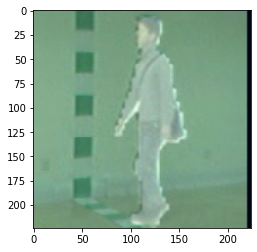

In [5]:
def rescale_to_1(val):
    return (val - val.min())/(val.max() - val.min())
idx = 10
norm_img = norm_imgs[idx]
norm_img = np.transpose(norm_img, (1, 2, 0))

s_imgs = silhouette_imgs[idx]
s_imgs = np.expand_dims(s_imgs, axis=2)
s_imgs = np.tile(s_imgs, (1,1,3))
s_imgs = cv2.resize(s_imgs, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
s_imgs.shape


img = rescale_to_1(norm_img) + .5*rescale_to_1(s_imgs)
img = rescale_to_1(img)
plt.imshow(img)

In [6]:
hmr = get_pretrained_hmr()
hmr.train()
hmr.training

True

In [7]:

vs_dataset = VideoSilhouetteDataset()
train_loader = DataLoader(vs_dataset, batch_size=2,
                                  num_workers=1, pin_memory=False, shuffle=True)

In [8]:
norm_imgs, silhouette_imgs, bboxes = next(iter(train_loader))
norm_imgs, silhouette_imgs, bboxes = norm_imgs.to(device), silhouette_imgs.to(device), bboxes.to(device)
norm_imgs = rearrange(norm_imgs, 'b f c h w -> (b f) c h w')
silhouette_imgs = rearrange(silhouette_imgs, 'b f h w -> (b f) h w')
bboxes = rearrange(bboxes, 'b f box -> (b f) box')

# hmr
print(norm_imgs.shape)
output = hmr(norm_imgs)
print(output[0].keys())

torch.Size([30, 3, 224, 224])
dict_keys(['theta', 'verts', 'kp_2d', 'kp_3d'])


### Point Cloud Projection

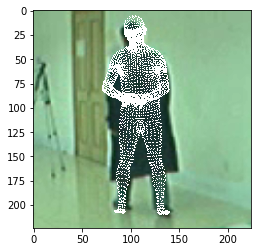

In [9]:
idx = 16
im_size = 224
img_2d = norm_imgs[idx].permute(dims=(1,2,0)).detach().cpu().numpy() # np.zeros((im_size, im_size, 3))
img_2d = rescale_to_1(img_2d)
pred_keypoints_2d = projection(output[0]['verts'], output[0]['theta']) #output['kp_3d'].squeeze()
pred_keypoints_2d = pred_keypoints_2d.detach().cpu().numpy()


kp_2d = (pred_keypoints_2d[idx] + 1)/2
for dot in kp_2d:
    if int(dot[1]*im_size) < im_size and int(dot[0]*im_size) < im_size:
        img_2d[int(dot[1]*im_size), int(dot[0]*im_size)] = 1
plt.imshow(img_2d)

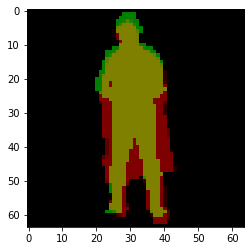

In [10]:
im_size = 64

# silhouette
img_2d = np.zeros((im_size, im_size, 3))
img_2d[:,:,0] = silhouette_imgs[idx].detach().cpu().numpy()
img_2d = rescale_to_1(img_2d)*.5
pred_keypoints_2d = projection(output[0]['verts'], output[0]['theta']) #output['kp_3d'].squeeze()
pred_keypoints_2d = pred_keypoints_2d.detach().cpu().numpy()

# point clound
kp_2d = (pred_keypoints_2d[idx] + 1)/2
for dot in kp_2d:
    if int(dot[1]*im_size) < im_size and int(dot[0]*im_size) < im_size:
        img_2d[int(dot[1]*im_size), int(dot[0]*im_size), 1] = .5
plt.imshow(img_2d)

### Differentiable Renderer

In [11]:
from pytorch3d.structures import Meshes
from lib.models.smpl import get_smpl_faces
from pytorch3d.renderer import (TexturesVertex, 
                            PointLights, 
                            FoVOrthographicCameras,
                            RasterizationSettings,
                            MeshRenderer,
                            MeshRasterizer,
                               SoftSilhouetteShader)
from lib.utils.demo_utils import convert_crop_cam_to_orig_img

### One sample

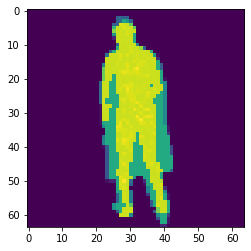

In [12]:
idx = 18
faces = get_smpl_faces()
face = torch.tensor(np.expand_dims(faces, axis=0).astype(np.float32)).to(device)
lights = PointLights(device=device, location=[[0.0, 0.0, 0.0]])

vert = output[0]['verts'][idx:idx+1].clone()
s, tx, ty = output[0]['theta'][idx, :3]


textures = TexturesVertex(verts_features=torch.ones_like(vert).to(device))
mesh = Meshes(vert, face, textures)

camera = FoVOrthographicCameras(device=device, T=[[tx,ty,1]], scale_xyz=[[s,s,1]])
raster_settings_silhouette = RasterizationSettings(
    image_size=(64,64), 
    blur_radius=1e-6, #np.log(1. / 1e-4 - 1.)*sigma
    faces_per_pixel=1, 
)
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)
pred_silhouette_images = renderer_silhouette(mesh, cameras=camera, lights=lights)
pred_silhouette_images = torch.flip(pred_silhouette_images, (1,2))
img = pred_silhouette_images[0,...,3].detach().cpu().numpy()
img = silhouette_imgs[idx].detach().cpu().numpy()/255 + img
plt.imshow(img)

### Batch Sample

In [13]:
transitions = output[0]['theta'][:,1:3]
scales = output[0]['theta'][:,0:1]
ones = torch.ones(transitions.shape[0], 1).cuda()

transitions = torch.cat((transitions, ones), dim=-1)
scales = torch.cat((scales, scales, ones.clone()), dim=-1)

torch.Size([30, 64, 64, 4])

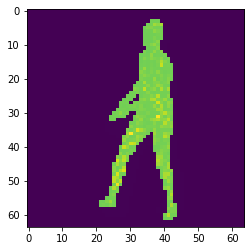

In [49]:
idx = 14
faces = get_smpl_faces()
face = torch.tensor(np.expand_dims(faces, axis=0)
                    .astype(np.float32)
                    .repeat(BATCH*NUM_FRAME,0)).to(device)
lights = PointLights(device=device, location=[[0.0, 0.0, 0.0]])

vert = output[0]['verts'].clone() # clone???
textures = TexturesVertex(verts_features=torch.ones_like(vert).to(device))
mesh = Meshes(vert, face, textures)
camera = FoVOrthographicCameras(device=device, T=transitions, scale_xyz=scales)
raster_settings_silhouette = RasterizationSettings(
    image_size=(64,64), 
    blur_radius=1e-6, #np.log(1. / 1e-4 - 1.)*sigma
    faces_per_pixel=1, 
)
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)
pred_silhouette_images = renderer_silhouette(mesh, cameras=camera, lights=lights)
pred_silhouette_images = torch.flip(pred_silhouette_images, (1,2))
img = pred_silhouette_images[idx,...,3].detach().cpu().numpy()
img = silhouette_imgs[idx].detach().cpu().numpy()/255 + img
plt.imshow(img)
pred_silhouette_images.shape

### ALL

In [15]:
import sys
sys.path.append('../')
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
import cv2
from einops import rearrange
from lib.models.spin import hmr, get_pretrained_hmr
from lib.models.spin import projection
import random
from pytorch3d.renderer import (TexturesVertex, 
                            PointLights, 
                            FoVOrthographicCameras,
                            RasterizationSettings,
                            MeshRenderer,
                            MeshRasterizer,
                               SoftSilhouetteShader)
from lib.models.smpl import get_smpl_faces
from pytorch3d.structures import Meshes
import torch.nn as nn

In [16]:
device = 'cuda'
NUM_FRAME = 15
BATCH = 2
class VideoSilhouetteDataset(Dataset):
    def __init__(self, transform=None):
        PATH = '/home/epinyoan/dataset/casia-b/dataset_b/all/crop_images/*'
        self.folders = list(glob.glob(PATH))
        self.transform = transform

    def __len__(self):
        return len(self.folders)

    def __getitem__(self, idx):
        paths = list(sorted(glob.glob(self.folders[idx]+'/*')))
        start_index = random.randint(0, len(paths)-NUM_FRAME)
        norm_imgs = []
        silhouette_imgs = []
        bboxes = []
        for i in range(NUM_FRAME):
            data = np.load(paths[start_index+i], allow_pickle=True)
            norm_imgs.append(data['norm_imgs'])
            silhouette_imgs.append(data['silhuette_imgs'])
            bboxes.append(data['bboxes'])
        return np.array(norm_imgs), np.array(silhouette_imgs), np.array(bboxes)
vs_dataset = VideoSilhouetteDataset()
train_loader = DataLoader(vs_dataset, batch_size=BATCH, num_workers=1, pin_memory=False, shuffle=True)
model = get_pretrained_hmr()
model.train()

# renderer
faces = get_smpl_faces()
lights = PointLights(device=device, location=[[0.0, 0.0, 0.0]])
raster_settings_silhouette = RasterizationSettings(
    image_size=(64,64), 
    blur_radius=1e-6, #np.log(1. / 1e-4 - 1.)*sigma
    faces_per_pixel=1, 
)

# loss
criterion_silhouette = nn.MSELoss().to(device)

In [50]:
for norm_imgs, silhouette_imgs, bboxes in train_loader:
    norm_imgs, silhouette_imgs, bboxes = norm_imgs.to(device), silhouette_imgs.to(device), bboxes.to(device)
    norm_imgs = rearrange(norm_imgs, 'b f c h w -> (b f) c h w')
    silhouette_imgs = rearrange(silhouette_imgs, 'b f h w -> (b f) h w')
    bboxes = rearrange(bboxes, 'b f box -> (b f) box')
    output = model(norm_imgs)
    
    ones = torch.ones(norm_imgs.shape[0], 1).to(device)
    face = torch.tensor(np.expand_dims(faces, axis=0)
                        .astype(np.float32)
                        .repeat(norm_imgs.shape[0], 0)).to(device)
    lights = PointLights(device=device, location=[[0.0, 0.0, 0.0]])
    textures = TexturesVertex(verts_features=torch.ones(
        norm_imgs.shape[0], 6890, 3).to(device))
    
    transitions = output[0]['theta'][:,1:3]
    scales = output[0]['theta'][:,0:1]
    transitions = torch.cat((transitions, ones), dim=-1)
    scales = torch.cat((scales, scales, ones.clone()), dim=-1)
    
    vert = output[0]['verts']
    mesh = Meshes(vert, face, textures)
    camera = FoVOrthographicCameras(device=device, T=transitions, scale_xyz=scales)
    renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
            cameras=camera, 
            raster_settings=raster_settings_silhouette
        ),
        shader=SoftSilhouetteShader()
    )
    pred_silhouette_images = renderer_silhouette(mesh, cameras=camera, lights=lights)
    pred_silhouette_images = torch.flip(pred_silhouette_images, (1,2))
    
    pred_silhouette_images = pred_silhouette_images[...,3] #torch.where(pred_silhouette_images[...,3]>0, 1, 0)
    pred_silhouette_images = torch.ceil(pred_silhouette_images)
    pred_silhouette_images.retain_grad()
    silhouette_imgs = silhouette_imgs/255
    loss = criterion_silhouette(pred_silhouette_images, silhouette_imgs)
    loss.backward()
    break

In [52]:
pred_silhouette_images.grad.max(), pred_silhouette_images.max()

(tensor(1.6276e-05, device='cuda:0'),
 tensor(1., device='cuda:0', grad_fn=<MaxBackward1>))

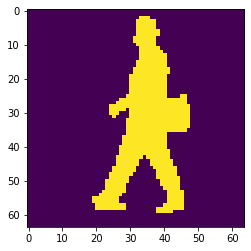

In [19]:
import matplotlib.pyplot as plt
idx = 5
img = torch.where(pred_silhouette_images[idx,...,3]>0, 1, 0).detach().cpu().numpy()
img = (silhouette_imgs[idx]>0).detach().cpu().numpy()/2 + img/2
plt.imshow(img)

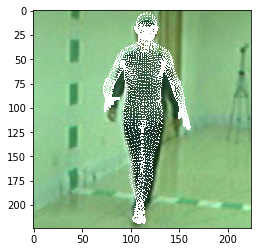

In [21]:
idx = 18
im_size = 224
img_2d = norm_imgs[idx].permute(dims=(1,2,0)).detach().cpu().numpy() # np.zeros((im_size, im_size, 3))
img_2d = rescale_to_1(img_2d)
pred_keypoints_2d = projection(output[0]['verts'], output[0]['theta']) #output['kp_3d'].squeeze()
pred_keypoints_2d = pred_keypoints_2d.detach().cpu().numpy()


kp_2d = (pred_keypoints_2d[idx] + 1)/2
for dot in kp_2d:
    if int(dot[1]*im_size) < im_size and int(dot[0]*im_size) < im_size:
        img_2d[int(dot[1]*im_size), int(dot[0]*im_size)] = 1
plt.imshow(img_2d)